# 次元削減

In [3]:
import sklearn as sk
import sklearn.decomposition as skd
import sklearn.discriminant_analysis as skda
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# 対象データの設定
DIRECTORIES = ["../windowed", "../windowed+boxcox"]
TIME_WINDOWS = [180, 240]
N_SAMPLES = 75
BLE_IDS_NEW = [15070, 15158, 15159, 15160, 15161]
BLE_IDS_OLD = [15153, 15155, 15162, 15163, 15164]

In [7]:
# 対象データのデータ数の確認
for directory in DIRECTORIES:
    for time_window in TIME_WINDOWS:
        df = pd.read_csv(f"{directory}/t={time_window}.csv")
        cnt = df.groupby(["label", "ble_id"]).size().min()
        print(f"{directory}/t={time_window}.csv", cnt)

../windowed/t=180.csv 78
../windowed/t=240.csv 78
../windowed+boxcox/t=180.csv 78
../windowed+boxcox/t=240.csv 78


## PCA による次元削減

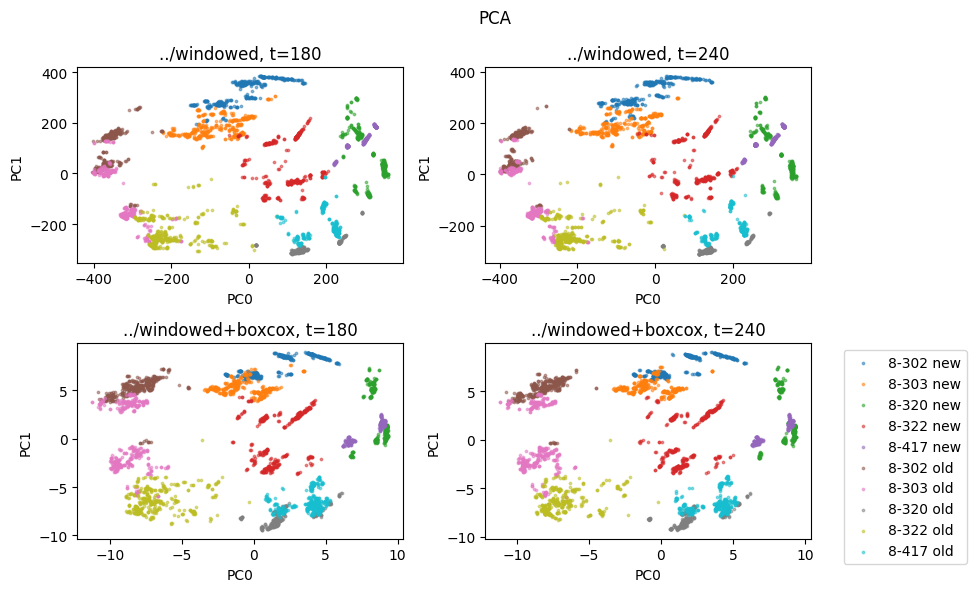

,PC0,PC1,Sum
"../windowed, t=180",0.406729,0.305708,0.712436
"../windowed, t=240",0.411893,0.306401,0.718294
"../windowed+boxcox, t=180",0.417217,0.352620,0.769838
"../windowed+boxcox, t=240",0.421552,0.353712,0.775265


In [24]:
# プロットの初期化
fig, ax = plt.subplots(len(DIRECTORIES), len(TIME_WINDOWS), figsize=(10, 6))
fig.suptitle("PCA")

# 寄与率表の初期化
df_explained_variance_ratio = pd.DataFrame()

for i, directory in enumerate(DIRECTORIES):
    for j, time_window in enumerate(TIME_WINDOWS):
        df = pd.read_csv(f"{directory}/t={time_window}.csv")
        df = df.groupby(["label", "ble_id"]).sample(n=N_SAMPLES, random_state=0)

        pca = skd.PCA(n_components=2)
        pca.fit(df.drop(["label", "ble_id"], axis=1))

        dfs = {
            "new": df[df["ble_id"].isin(BLE_IDS_NEW)],
            "old": df[df["ble_id"].isin(BLE_IDS_OLD)],
        }

        for ble_id_type, typed_df in dfs.items():
            for label, df in typed_df.groupby("label"):
                ax[i][j].scatter(
                    pca.transform(df.drop(["label", "ble_id"], axis=1))[:, 0],
                    pca.transform(df.drop(["label", "ble_id"], axis=1))[:, 1],
                    label=f"{label} {ble_id_type}",
                    alpha=0.5,
                    s=3
                )

        ax[i][j].set_title(f"{directory}, t={time_window}")
        ax[i][j].set_xlabel("PC0")
        ax[i][j].set_ylabel("PC1")

        # 寄与率の保存
        df_explained_variance_ratio[f"{directory}, t={time_window}"] = {
            "PC0": pca.explained_variance_ratio_[0],
            "PC1": pca.explained_variance_ratio_[1],
            "Sum": pca.explained_variance_ratio_.sum()
        }

ax[-1][-1].legend(loc="upper right", bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.show()

display(df_explained_variance_ratio.T)

## LDA による次元削減

          8-302-0     8-302-1  8-303-0     8-303-1     8-320-0     8-320-1  \
150    130.511667   36.423722    300.0  165.636667  300.000000  300.000000   
56     105.818888   47.280125    300.0  143.842000  300.000000  300.000000   
123     85.153771   42.603900    300.0  179.007500  300.000000  300.000000   
60     108.389787   45.363556    300.0  143.410667  300.000000  300.000000   
100     54.152390   28.134262    300.0  153.445333  300.000000  300.000000   
...           ...         ...      ...         ...         ...         ...   
19780  300.000000  300.000000    300.0   70.794600   73.817510   93.586633   
19814  300.000000  300.000000    300.0  300.000000   73.548517   92.471250   
19786  300.000000  300.000000    300.0   70.794600   73.817510   92.471250   
19839  300.000000  300.000000    300.0  300.000000   73.687325   82.818950   
19309  300.000000  300.000000    300.0  300.000000   90.045480   89.125100   

          8-322-0     8-322-1     8-417-0  
150    300.000000  

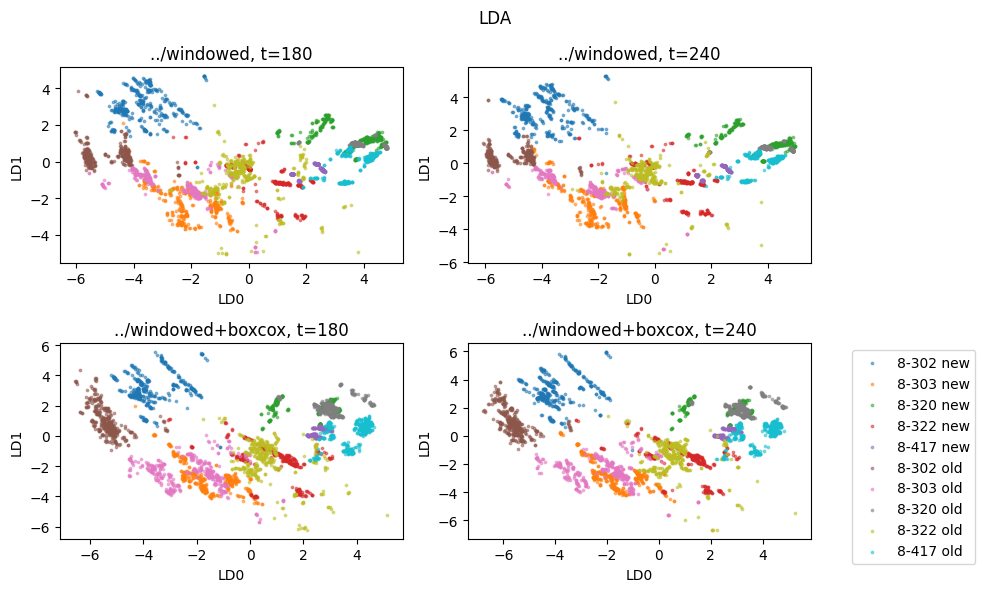

n_components=2


,LD0,LD1,Sum
../windowed t=180,0.768063,0.137743,0.905806
../windowed t=240,0.780592,0.134103,0.914695
../windowed+boxcox t=180,0.582739,0.241954,0.824693
../windowed+boxcox t=240,0.599412,0.234615,0.834027


n_components=3


,LD0,LD1,LD2,Sum
../windowed t=180,0.768063,0.137743,0.080707,0.986514
../windowed t=240,0.780592,0.134103,0.073003,0.987698
../windowed+boxcox t=180,0.582739,0.241954,0.139101,0.963794
../windowed+boxcox t=240,0.599412,0.234615,0.133587,0.967615


n_components=4


,LD0,LD1,LD2,LD3,Sum
../windowed t=180,0.768063,0.137743,0.080707,0.013486,1.0
../windowed t=240,0.780592,0.134103,0.073003,0.012302,1.0
../windowed+boxcox t=180,0.582739,0.241954,0.139101,0.036206,1.0
../windowed+boxcox t=240,0.599412,0.234615,0.133587,0.032385,1.0


In [27]:
N_COMPONENTS_LIST = [2, 3, 4]
# プロットの初期化
fig, ax = plt.subplots(len(DIRECTORIES), len(TIME_WINDOWS), figsize=(10, 6))
fig.suptitle("LDA")

# 寄与率表の初期化
df_explained_variance_ratio_dict = {n_components : pd.DataFrame() for n_components in N_COMPONENTS_LIST}

for n_components in N_COMPONENTS_LIST:
    for i, directory in enumerate(DIRECTORIES):
        for j, time_window in enumerate(TIME_WINDOWS):
            df = pd.read_csv(f"{directory}/t={time_window}.csv")
            df = df.groupby(["label", "ble_id"]).sample(n=N_SAMPLES, random_state=0)

            lda = skda.LinearDiscriminantAnalysis(n_components=n_components)
            lda.fit(df.drop(["label", "ble_id"], axis=1), df["label"])

            # 寄与率の保存
            record = {
                f"LD{i}" : lda.explained_variance_ratio_[i] for i in range(n_components)
            }
            record["Sum"] = lda.explained_variance_ratio_.sum()
            df_explained_variance_ratio_dict[n_components][f"{directory} t={time_window}"] = record

            dfs = {
                "new": df[df["ble_id"].isin(BLE_IDS_NEW)],
                "old": df[df["ble_id"].isin(BLE_IDS_OLD)],
            }
            # n_componentsが2の場合のみプロット
            if n_components == 2:
                for ble_id_type, typed_df in dfs.items():
                    for label, df in typed_df.groupby("label"):
                        ax[i][j].scatter(
                            lda.transform(df.drop(["label", "ble_id"], axis=1))[:, 0],
                            lda.transform(df.drop(["label", "ble_id"], axis=1))[:, 1],
                            label=f"{label} {ble_id_type}",
                            alpha=0.5,
                            s=3
                        )
                ax[i][j].set_title(f"{directory}, t={time_window}")
                ax[i][j].set_xlabel("LD0")
                ax[i][j].set_ylabel("LD1")

ax[-1][-1].legend(loc="upper right", bbox_to_anchor=(1.5, 1.0))
plt.tight_layout()
plt.show()

for n_components, df_explained_variance_ratio in df_explained_variance_ratio_dict.items():
    print(f"n_components={n_components}")
    display(df_explained_variance_ratio.T)
